In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import warnings
import time, copy

import utils
import TIRE
import simulate

In [2]:
window_size = 20
domain = "TD" #choose from: TD (time domain), FD (frequency domain) or both

#parameters TD
intermediate_dim_TD=0
latent_dim_TD=1 #h^TD in paper
nr_shared_TD=1 #s^TD in paper
K_TD = 2 #as in paper
nr_ae_TD= K_TD+1 #number of parallel AEs = K+1
loss_weight_TD=1 #lambda_TD in paper

#parameters FD
intermediate_dim_FD=10
latent_dim_FD=1 #h^FD in paper
nr_shared_FD=1 #s^FD in paper
K_FD = 2 #as in paper
nr_ae_FD=K_FD+1 #number of parallel AEs = K+1
loss_weight_FD=1 #lambda^FD in paper
nfft = 30 #number of points for DFT
norm_mode = "timeseries" #for calculation of DFT, should the timeseries have mean zero or each window?

In [3]:
import scipy.io
import TIRE

In [4]:
import pandas as pd

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import utils

In [6]:
def get_ECG(window_size, stride=1, scale_min=-1, scale_max=1):
    mat=scipy.io.loadmat('ECG200.mat')
    y = pd.DataFrame(mat['Y'])
    l = np.array(pd.DataFrame(mat['L']).T)
    timeseries = np.linalg.norm(np.array(y), axis=1)
    windows = utils.ts_to_windows(timeseries, 0, window_size, stride)
    windows = utils.minmaxscale(windows,scale_min,scale_max)
    return timeseries, windows, l

In [7]:
timeseries, windows_TD, parameters = get_ECG(window_size)
windows_FD = utils.calc_fft(windows_TD, nfft, norm_mode)

In [8]:
shared_features_TD = TIRE.train_AE(windows_TD, intermediate_dim_TD, latent_dim_TD, nr_shared_TD, nr_ae_TD, loss_weight_TD)
shared_features_FD = TIRE.train_AE(windows_FD, intermediate_dim_FD, latent_dim_FD, nr_shared_FD, nr_ae_FD, loss_weight_FD)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3, 20)]              0         []                            
                                                                                                  
 dense (Dense)               (None, 3, 1)                 21        ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 3, 0)                 0         ['input_1[0][0]']             
                                                                                                  
 tf.concat (TFOpLambda)      (None, 3, 1)                 0         ['dense[0][0]',               
                                                                     'dense_1[0][0]']         

In [9]:
dissimilarities = TIRE.smoothened_dissimilarity_measures(shared_features_TD, shared_features_FD, domain, window_size)
change_point_scores = TIRE.change_point_score(dissimilarities, window_size)

In [10]:
breakpoints = utils.parameters_to_cps(parameters,window_size)

[0.13825767803549857, 0.3751357193944974, 0.41727074851764767]


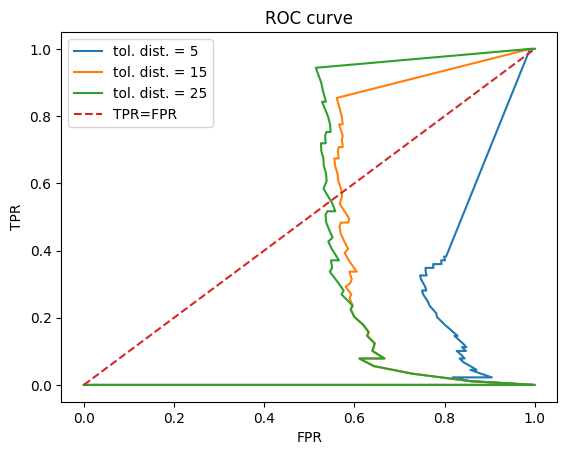

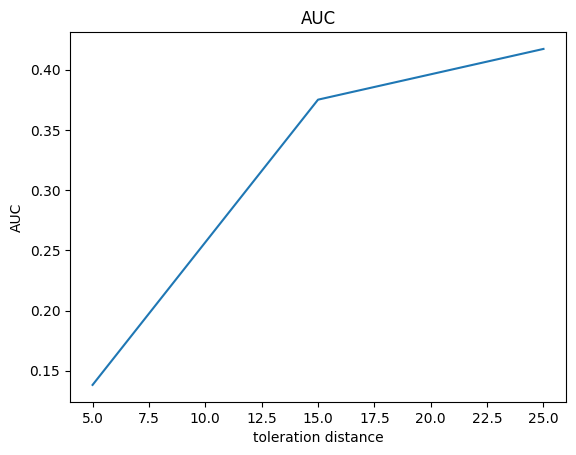

In [11]:
tol_distances = [5,15,25]
auc = utils.get_auc(dissimilarities,tol_distances, parameters, window_size)